In [143]:
#Importing relevant packages
import numpy as np 
import pandas as pd
from tqdm import tqdm #to create a progress bar

#Packages for NLP
import nltk
from nltk.tokenize import TweetTokenizer

#Machine learning packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Packages to create DFM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Packages for cross-validation and parameter tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Packages for getting model performance metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Supervised learning 

For this exercise lab, the goal is to apply supervised machine learning to predict which tweets are from Republicans and from Democrats on Twitter. 

The dataset is the same as the one we used Monday and last week, containing tweets from US Members of Congress. The preprocessed version is also the same as the one used on Monday. 

We will be applying two supervised machine learning algorithms - random forest and lasso - and comparing which method performs best when predicting party affiliation from tweet text. 


### 1.1: Preparing the data for analysis 

1. Import the dataframe
2. Similar to last week, replace NaN values with an empty string in the stemmed text. Then use `groupby` and `agg` to group the data by politician (nominate_name), and aggregate the stemmed tweet text for each politician into one long string. 
3. Create a column with a binary label to show party affiliation. 0 if Republican, 1 if Democrat. 


In [2]:
#Importing data 
tweets = pd.read_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

#Removing unnamed columns
tweets = tweets.drop(labels="Unnamed: 0", axis = 1)

In [3]:
#Viewing dataframe
tweets.head()

,date,text,affiliation,nominate_name,text_lemma,text_stemmed
0,2019-03-19,Federal government employees are dedicated pub...,Republican,"BOOZMAN, John",federal government employee dedicate public se...,feder govern employe dedic public servant prov...
1,2019-09-13,.@DeptVetAffairs recently rolled out a new dig...,Republican,"BOOZMAN, John",recently roll new digital memorial platform mi...,recent roll new digit memori platform million ...
2,2019-09-12,I know the importance of empowering women in t...,Republican,"BOOZMAN, John",know importance empower woman global economy s...,know import empow women global economi sponsor...
3,2019-03-22,It was great to spend some time with leaders i...,Republican,"BOOZMAN, John",great spend time leader van buren county talk ...,great spend time leader van buren counti talk ...
4,2019-09-18,"For 72 years, @usairforce has been blazing the...",Republican,"BOOZMAN, John",year blaze trail dominance air space cyberspac...,year blaze trail domin air space cyberspac dad...


In [4]:
#Replacing nan values with empty strings
tweets.text_lemma = tweets.text_lemma.apply(lambda x: '' if str(x) == 'nan' else x)
tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)

In [5]:
#Aggregating text for each politician 

tweets_agg = tweets.groupby(['nominate_name','affiliation'], as_index = False).agg({'text': ' '.join,
                                                                                    'text_lemma': ' '.join,
                                                                                    'text_stemmed': ' '.join})


In [6]:
#Creating column with label 
tweets_agg['democrat'] = tweets_agg.affiliation.apply(lambda x: 1 if x == 'Democrat' else 0)


### 2: Creating a validation set and splitting features (X) and labels (y)

We'll pretend that we only know for 300 of the politicians whether they are Republicans or Democrats. For the remaining politicians, we therefore don't know the author's partisanship. Our goal then, is to use machine learning models to predict whether a user is a Republican or Democrat using the 218 labeled observations in our training set. Then we'll use a machine learning model that we have fit to the training data to predict the label for the unlabeled politicians.

1. Split the dataset into two: one labeled and one unlabeled. You can use `sample` on the aggregated dataframe to get a random sample of 300 politicians for the unlabeled dataset. The labeled dataset should be the remaining 218 politicians. 
3. Create a training set by splitting the labeled data into: X (the stemmed text) and y (the newly created binary label column). 

In [7]:
#Creating hold-out dataset of 300 unlabelled politicians
unlabeled = tweets_agg.sample(n = 300, axis = 0)

#Creating the labeled dataset by dropping all index values in the unlabeled dataset from the full dataset
labeled = tweets_agg
labeled = labeled.drop(unlabeled.index, axis=0)

print('Shape of labeled dataset:',labeled.shape,
      '\nShape of unlabeled dataset:',unlabeled.shape)


Shape of labeled dataset: (218, 6) 
Shape of unlabeled dataset: (300, 6)


In [8]:
#Splitting features into X and y
X = labeled['text_stemmed']
y = labeled['democrat'].values

### 4.1: RandomForest: Hyperparameter tuning

Now we begin with the supervised learning. First, we will train and tune a RandomForest classifier. Find the documentation for RandomForest here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

To use text data for prediction, we need to convert the data into a document-feature matrix. We will be comparing two methods of vectorization: a vectorizer using term frequencies and a transformation of those into tf-idf frequencies. 


Create a **pipeline** containing: 

1. `CountVectorizer`: 
    - Like Monday, we want to include both unigrams and bigrams. `CountVectorizer` can do this for us with the parameter `ngram_range`. 
    - Use the parameters `max_df` and `min_df` to remove very frequent (those that appear in more than 99.9% of the documents) and very infrequent words (those that appear in less than 10.0% documents).
    - CountVectorizer has a build-in tokenizer. However, if you want to use the `TweetTokenizer` we used on Monday, you can override the default tokenization with your own defined function, like so: `vectorizer = CountVectorizer(tokenizer=your_tokenizer.tokenize)`. <br>


2. `TfidfTransformer()` <br>


3. `RandomForestClassifier()`


Create a **parameter-grid** containing: 

1. To easily test the use of either term frequencies or tf-idf frequencies as part of your hyperparameter-tuning, use the parameter `use_idf` in the `TfidfTransformer()` in the pipeline.
2. Experiment with the `max_features` parameter (the number of features to consider when splitting branches). To get a model that runs (fairly) quickly, try: [260,300,340]. Other parameters that could also be experimented with, but only if you have a lot of time, are `n_estimators` (number of trees) and `max_depth` (size of the trees).


Use `StratifiedKFold` with 5 folds for **cross-validation**. This creates balanced distributions across the folds. 

Use `GridSearchCV` to **find the best RandomForest classifier**. Save the best performing model and compute the accuracy.

Investigate the results. Does the count vectorized data or the tf-idf vectorized data perform better? 


Note: `TfidfVectorizer` is the same as using `CountVectorizer` followed by `TfidfTransformer`. If you at a later point, e.g. for your exam, know that you want to use the tf-idf frequencies rather than the plain term frequencies, this is an option. 


In [11]:
#Initializing the tokenizer I want to use
tweet_tokenizer = TweetTokenizer()

#Initializing the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,2), max_df = 0.999, min_df = 0.10, tokenizer = tweet_tokenizer.tokenize)),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier()),
])

#Setting the parameter grid 
parameter_grid = {
    'tfidf__use_idf': [True, False],
    'rf__max_features' :[10, 260, 300, 340, 1000, 3000]}

#Initializing a kfold with 5 folds
cv = StratifiedKFold(n_splits=5)

#Initializing the GridSearchCV
search = GridSearchCV(pipeline, parameter_grid, cv=cv, verbose=10)

In [12]:
#Running the GridSearchCV

#As I experimented with more parameter values, this takes approx. 17 mins to run

result = search.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] rf__max_features=10, tfidf__use_idf=True ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__max_features=10, tfidf__use_idf=True, score=1.000, total=  16.3s
[CV] rf__max_features=10, tfidf__use_idf=True ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=True, score=0.932, total=  16.4s
[CV] rf__max_features=10, tfidf__use_idf=True ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.8s remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=True, score=0.932, total=  16.9s
[CV] rf__max_features=10, tfidf__use_idf=True ........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.8s remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=True, score=0.953, total=  16.7s
[CV] rf__max_features=10, tfidf__use_idf=True ........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=True, score=1.000, total=  16.7s
[CV] rf__max_features=10, tfidf__use_idf=False .......................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=False, score=0.977, total=  16.5s
[CV] rf__max_features=10, tfidf__use_idf=False .......................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=False, score=0.909, total=  16.5s
[CV] rf__max_features=10, tfidf__use_idf=False .......................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.9min remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=False, score=0.932, total=  16.8s
[CV] rf__max_features=10, tfidf__use_idf=False .......................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.2min remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=False, score=0.977, total=  16.7s
[CV] rf__max_features=10, tfidf__use_idf=False .......................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.5min remaining:    0.0s


[CV]  rf__max_features=10, tfidf__use_idf=False, score=0.930, total=  16.6s
[CV] rf__max_features=260, tfidf__use_idf=True .......................
[CV]  rf__max_features=260, tfidf__use_idf=True, score=1.000, total=  16.6s
[CV] rf__max_features=260, tfidf__use_idf=True .......................
[CV]  rf__max_features=260, tfidf__use_idf=True, score=0.955, total=  16.7s
[CV] rf__max_features=260, tfidf__use_idf=True .......................
[CV]  rf__max_features=260, tfidf__use_idf=True, score=0.955, total=  16.9s
[CV] rf__max_features=260, tfidf__use_idf=True .......................
[CV]  rf__max_features=260, tfidf__use_idf=True, score=0.953, total=  17.0s
[CV] rf__max_features=260, tfidf__use_idf=True .......................
[CV]  rf__max_features=260, tfidf__use_idf=True, score=1.000, total=  16.8s
[CV] rf__max_features=260, tfidf__use_idf=False ......................
[CV]  rf__max_features=260, tfidf__use_idf=False, score=1.000, total=  16.6s
[CV] rf__max_features=260, tfidf__use_idf

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 17.2min finished


In [13]:
#Finding the best performing model and saving it 
bestforest = result.best_estimator_

#Viewing the parameters and accuracy of the best performing model 
print('Parameters of the best RandomForest classifier:',result.best_params_,
      '\nAvg. accuracy score of the best performing model:',result.best_score_)


Parameters of the best RandomForest classifier: {'rf__max_features': 300, 'tfidf__use_idf': True} 
Avg. accuracy score of the best performing model: 0.9863636363636363


In [104]:
#Investigate the difference between using plain frequencies and tf-idf

#Saving the results of all parameters in a dataframe
result_df = pd.DataFrame(result.cv_results_)

#Locating and printing the accuracy results of the two vectorizers 
print('Result of best model with tf-idf vectorizing:\t',
      result_df.loc[(result_df.param_tfidf__use_idf == True) 
                    & (result_df.param_rf__max_features == 300)]['mean_test_score'].values)

print('Result of best model with count vectorizing:\t',
      result_df.loc[(result_df.param_tfidf__use_idf == False) 
                    & (result_df.param_rf__max_features == 300)]['mean_test_score'].values)


#No real difference to be spotted here. 
#The model seems to perform so well generally that the difference between using a count vectorizer 
#     and a tf-idf vectorizer are minimal


Result of best model with tf-idf vectorizing:	 [0.98636364]
Result of best model with count vectorizing:	 [0.98636364]


### 4.2: Lasso: Supervised learning and hyperparameter tuning

Repeat the above steps to find the best performing lasso regression model. 

To implement lasso regression, we will use scikit-learn's `LogisticRegression` with `penalty = 'l1'`, `solver = 'saga'`, and bumping up `max_iter = 1000`. 

The parameter to cross-validate will be `C`, the inverse of regularization strength (1/λ). Experiment with the parameter values [0.5, 1, 5].


In [20]:
#Initializing the tokenizer I want to use
tweet_tokenizer = TweetTokenizer()

#Initializing the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,2), max_df = 0.999, min_df = 0.10, tokenizer = tweet_tokenizer.tokenize)),
    ('tfidf', TfidfTransformer()),
    ('lasso', LogisticRegression(penalty = 'l1', solver = 'saga', max_iter = 1000)),
])

#Setting the parameter grid 
parameter_grid = {
    'tfidf__use_idf': [True, False],
    'lasso__C': [0.05, 0.1, 0.5, 1, 5]}

#Initializing a kfold with 5 folds
cv = StratifiedKFold(n_splits=5)

lasso_search = GridSearchCV(pipeline, parameter_grid, cv=cv, verbose=10)


In [21]:
#As I experimented with more parameter values, this takes approx. 15 mins to run

lasso_result = lasso_search.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] lasso__C=0.05, tfidf__use_idf=True ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. lasso__C=0.05, tfidf__use_idf=True, score=0.545, total=  16.6s
[CV] lasso__C=0.05, tfidf__use_idf=True ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s


[CV] .. lasso__C=0.05, tfidf__use_idf=True, score=0.545, total=  16.7s
[CV] lasso__C=0.05, tfidf__use_idf=True ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.4s remaining:    0.0s


[CV] .. lasso__C=0.05, tfidf__use_idf=True, score=0.455, total=  17.1s
[CV] lasso__C=0.05, tfidf__use_idf=True ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.6s remaining:    0.0s


[CV] .. lasso__C=0.05, tfidf__use_idf=True, score=0.558, total=  17.0s
[CV] lasso__C=0.05, tfidf__use_idf=True ..............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV] .. lasso__C=0.05, tfidf__use_idf=True, score=0.535, total=  16.8s
[CV] lasso__C=0.05, tfidf__use_idf=False .............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s


[CV] . lasso__C=0.05, tfidf__use_idf=False, score=0.545, total=  16.6s
[CV] lasso__C=0.05, tfidf__use_idf=False .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s


[CV] . lasso__C=0.05, tfidf__use_idf=False, score=0.545, total=  16.8s
[CV] lasso__C=0.05, tfidf__use_idf=False .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.0min remaining:    0.0s


[CV] . lasso__C=0.05, tfidf__use_idf=False, score=0.545, total=  17.4s
[CV] lasso__C=0.05, tfidf__use_idf=False .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s


[CV] . lasso__C=0.05, tfidf__use_idf=False, score=0.558, total=  16.9s
[CV] lasso__C=0.05, tfidf__use_idf=False .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.5min remaining:    0.0s


[CV] . lasso__C=0.05, tfidf__use_idf=False, score=0.535, total=  16.8s
[CV] lasso__C=0.1, tfidf__use_idf=True ...............................
[CV] ... lasso__C=0.1, tfidf__use_idf=True, score=0.545, total=  16.7s
[CV] lasso__C=0.1, tfidf__use_idf=True ...............................
[CV] ... lasso__C=0.1, tfidf__use_idf=True, score=0.545, total=  16.7s
[CV] lasso__C=0.1, tfidf__use_idf=True ...............................
[CV] ... lasso__C=0.1, tfidf__use_idf=True, score=0.545, total=  17.0s
[CV] lasso__C=0.1, tfidf__use_idf=True ...............................
[CV] ... lasso__C=0.1, tfidf__use_idf=True, score=0.558, total=  17.0s
[CV] lasso__C=0.1, tfidf__use_idf=True ...............................
[CV] ... lasso__C=0.1, tfidf__use_idf=True, score=0.465, total=  16.9s
[CV] lasso__C=0.1, tfidf__use_idf=False ..............................
[CV] .. lasso__C=0.1, tfidf__use_idf=False, score=0.545, total=  16.8s
[CV] lasso__C=0.1, tfidf__use_idf=False ..............................
[CV] .

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] ..... lasso__C=5, tfidf__use_idf=True, score=0.884, total=  22.5s
[CV] lasso__C=5, tfidf__use_idf=True .................................
[CV] ..... lasso__C=5, tfidf__use_idf=True, score=1.000, total=  20.3s
[CV] lasso__C=5, tfidf__use_idf=False ................................
[CV] .... lasso__C=5, tfidf__use_idf=False, score=0.932, total=  20.9s
[CV] lasso__C=5, tfidf__use_idf=False ................................
[CV] .... lasso__C=5, tfidf__use_idf=False, score=0.932, total=  21.6s
[CV] lasso__C=5, tfidf__use_idf=False ................................
[CV] .... lasso__C=5, tfidf__use_idf=False, score=0.932, total=  21.0s
[CV] lasso__C=5, tfidf__use_idf=False ................................
[CV] .... lasso__C=5, tfidf__use_idf=False, score=0.884, total=  21.5s
[CV] lasso__C=5, tfidf__use_idf=False ................................
[CV] .... lasso__C=5, tfidf__use_idf=False, score=1.000, total=  19.2s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 15.1min finished


In [22]:
#Finding the best performing model and saving it 
bestlasso = lasso_result.best_estimator_

print('Parameters of the best Lasso model:',lasso_result.best_params_,
      '\nAvg. accuracy score of the best performing model:',lasso_result.best_score_)


Parameters of the best Lasso model: {'lasso__C': 5, 'tfidf__use_idf': True} 
Avg. accuracy score of the best performing model: 0.9403805496828752


In [105]:
#Investigate the difference between using plain frequencies and tf-idf

#Saving the results of all parameters in a dataframe
lasso_result_df = pd.DataFrame(lasso_result.cv_results_)

#Locating and printing the accuracy results of the two vectorizers with the optimal C parameter value
print('Result of best model with tf-idf vectorizing:\t',
      lasso_result_df.loc[(lasso_result_df.param_tfidf__use_idf == True)
                          & (lasso_result_df.param_lasso__C == 5)]['mean_test_score'].values)

print('Result of best model with count vectorizing:\t',
      lasso_result_df.loc[(lasso_result_df.param_tfidf__use_idf == False)
                    & (lasso_result_df.param_lasso__C == 5)]['mean_test_score'].values)


#Here we see that the tf-idf vectorizing performs better than the count vectorizer. 


Result of best model with tf-idf vectorizing:	 [0.94038055]
Result of best model with count vectorizing:	 [0.9358351]


### 5. Performance evaluation

Now that we have our two best performing models, let's try them on data the models have never seen. Normally we couldn't "check" to see how well we labeled our unlabeled data, because they are... unlabeled. But for this example we actually can do that because in all of our data we know who actually is a Democrat or Republican. Split the unlabeled dataset into X_test and y_test. 

Fit the best models with the labeled data.

1. Plot a confusion-matrix for the best performing RandomForest and the best performing Lasso. Scikit-learn's `plot_confusion_matrix` can do this for you. 
2. Compute accuracy, precision, recall, and f1 for each best performing model. Compute predicted y and then use `classification_report` to get the performance scores. 
3. Compute the AUC-score (area-under-the-curve) and plot the ROC-curve for each model. Code is provided. 

Which method performs best?


In [111]:
sns.set_style("white")

In [112]:
#Splitting unlabeled features into X and y
Xnew = unlabeled['text_stemmed']
ynew = unlabeled['democrat'].values


#### Confusion matrices

Accuracy and confusion matrix for best RandomForestClassifier
0.9633333333333334


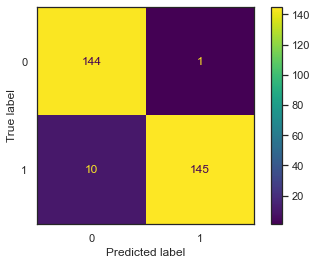

In [113]:
print('Accuracy and confusion matrix for best RandomForestClassifier')

#Fitting the best model with the labeled dataset
bestforest.fit(X, y)

#Getting the accuracy score
print(bestforest.score(Xnew, ynew))

#Confusion matrix RandomForest 
plot_confusion_matrix(bestforest, Xnew, ynew)  
plt.show()

Accuracy and confusion matrix for best Lasso
0.9133333333333333


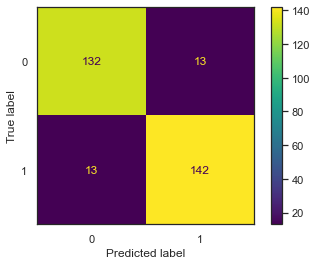

In [114]:
print('Accuracy and confusion matrix for best Lasso')

#Fitting the best model with the labeled dataset
bestlasso.fit(X, y)

#Getting the accuracy score
print(bestlasso.score(Xnew, ynew))

#Confusion matrix Lasso 
plot_confusion_matrix(bestlasso, Xnew, ynew)  
plt.show()

#### Accuracy, precision, recall, and f1-score

In [115]:
#Getting predicted values with RandomForest
ypred = bestforest.predict(Xnew)

#Getting classification report for RandomForest
print(classification_report(ypred,ynew))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       154
           1       0.94      0.99      0.96       146

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.97      0.96      0.96       300



In [116]:
#Getting predicted values with Lasso
ypred = bestlasso.predict(Xnew)

#Getting classification report for Lasso
print(classification_report(ypred,ynew))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       145
           1       0.92      0.92      0.92       155

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



#### AUC-score and ROC curve

For this, we are borrowing code from the documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 

Just fill in the blanks. 

In [136]:
#We have a binary classification - therefore, 2 classes
n_classes = 2

#Defining dictionaries to save scores for each class
fpr = dict() #Increasing false positive rates
tpr = dict() #Increasing true positive rates
roc_auc = dict() #AUC-score

#The predicted probabilities based on the unseen data - fill in here.
probs = bestforest.predict_proba(Xnew)

#For each class, fill in dictionaries with values
for i in range(n_classes):
    fpr[i], tpr[i], threshold = roc_curve(ynew, probs[:, i]) #Using scikit-learn's roc_curve function to get values
    roc_auc[i] = auc(fpr[i], tpr[i]) #Using scikit-learn's auc function to get the auc-score


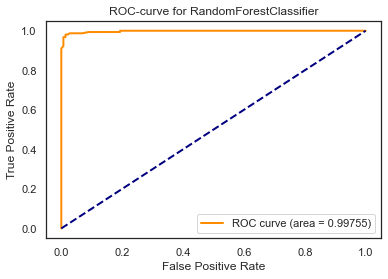

In [137]:
plt.figure()

#Setting linewidth
lw = 2

#Plotting the ROC-curve for class 1 (aka prediction of Democrat) with AUC-score as the legend
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.5f)' % roc_auc[1])

#Plotting the 'no skill' line, i.e. the line predicting 0 and 1 equally
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

#Adding embellishments ;) 
plt.title('ROC-curve for RandomForestClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Plotting AUC-score as legend
plt.legend(loc="lower right")

plt.show()


In [133]:
#Repeating above steps for Lasso 

n_classes = 2

fpr = dict()
tpr = dict()
roc_auc = dict()

probs = bestlasso.predict_proba(Xnew)

for i in range(n_classes):
    fpr[i], tpr[i], threshold = roc_curve(ynew, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

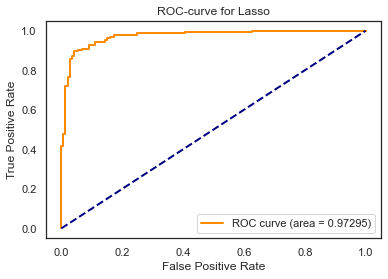

In [134]:
#Plotting the ROC-curve and AUC-score for Lasso

plt.figure()

lw = 2

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.5f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.title('ROC-curve for Lasso')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

plt.show()

### Interpreting feature important for prediction

Hooray, RandomForestClassifier is the best model! 

To see which features were important for prediction, extract the feature importances from the best performing model using `model.named_steps['insert pipeline step'].feature_importances_`. 

Combining these with `model.named_steps['insert pipeline step'].get_feature_names()` from the vectorizer, find the 20 most important words for prediction. 

Does it qualitatively make sense to you that these are the most important words to predict Democrats vs. Republicans from tweet text? 

If you have time, plot the 10 largest feature importances with `sns.barplot`. 

Hint: This can be solved similarly to the way the largest beta values and associated words were extracted in the topic modelling exercise. 

Optional: The most impactful coefficients can also be extracted from Lasso, in a similar way. Just remember to extract the 20 largest coefficients in *absolute* value. 

#### Extracting feature importances from RandomForest classifier

In [138]:
#Getting the feature names 
feature_names = np.array(bestforest.named_steps["vect"].get_feature_names())
feature_names.shape


(18422,)

In [140]:
#Getting the feature importances
feat_importances = bestforest.named_steps['rf'].feature_importances_
feat_importances.shape


(18422,)

In [141]:
#Creating a dataframe of feature names and importances 

#np.vstack stacks to arrays vertically on top of each other. 
#.T transposes the 2D array so feature names and importances become columns

feature_importance = pd.DataFrame(np.vstack((feature_names, feat_importances)).T, 
                                  columns = ['feat_name', 'feat_importance'])


In [142]:
#feat_importance are strings. Converting to float. 
feature_importance['feat_importance'] = feature_importance['feat_importance'].astype(float)

In [144]:
#Viewing the top 20 features 
feature_importance.nlargest(20, 'feat_importance')


,feat_name,feat_importance
243,#protectourcar,0.036095
6895,gun,0.032788
16746,violenc,0.029689
9802,mcconnel,0.028258
2885,climat,0.026657
9188,lgbtq,0.024325
6906,gun violenc,0.022052
344,#vawa,0.019982
71,#endgunviol,0.018973
5260,equal,0.017902


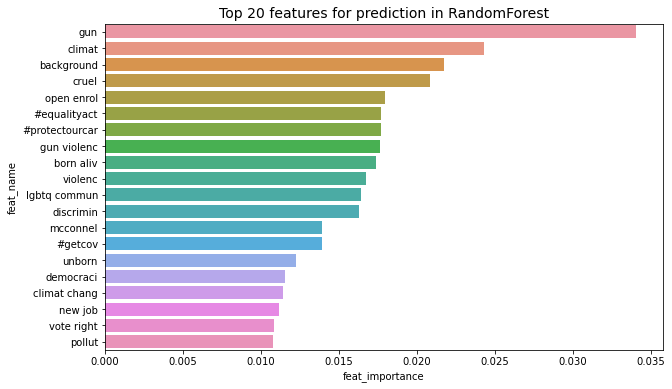

In [88]:
#Plotting the top 20 features in a barplot

plt.figure(figsize = (10,6))

sns.barplot(x = 'feat_importance',
            y = 'feat_name',
            data = feature_importance.nlargest(20, 'feat_importance'))

plt.title('Top 20 features for prediction in RandomForest', fontsize = 14);


#### Extracting coefficients from Lasso

In [70]:
#Creating a dataframe with lasso coefficients (similar to above)
lasso_coefs = pd.DataFrame(np.vstack((feature_names, bestlasso.named_steps['lasso'].coef_)).T, 
                                  columns = ['feat_name', 'coef'])


In [74]:
#Converting column values from string type to float
lasso_coefs['coef'] = lasso_coefs['coef'].astype(float)

In [89]:
#Sort the features by the absolute value of their coefficient

#Creating a column for absolute values
lasso_coefs["abs_value"] = lasso_coefs["coef"].apply(lambda x: abs(x))

#Creating a column of colors, based on whether the coefficient is positive or negative 
#(This step is not necessary - just for nice visualization)
lasso_coefs["colors"] = lasso_coefs["coef"].apply(lambda x: "green" if x > 0 else "red")

#Sorting the dataframe based on the absolute value column
lasso_coefs = lasso_coefs.sort_values("abs_value", ascending=False)


In [91]:
#Viewing the top 20 most impactful coefficients
lasso_coefs[:20]

,feat_name,coef,abs_value,colors
4301,democrat,-22.749740,22.749740,red
6895,gun,21.898168,21.898168,green
16099,trump,15.707776,15.707776,green
16827,vote,12.077867,12.077867,green
6760,great,-11.450645,11.450645,red
17447,work,8.838976,8.838976,green
11241,pass,8.443103,8.443103,green
550,act,5.277163,5.277163,green
13183,right,4.464885,4.464885,green
18333,️,-4.067177,4.067177,red


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)


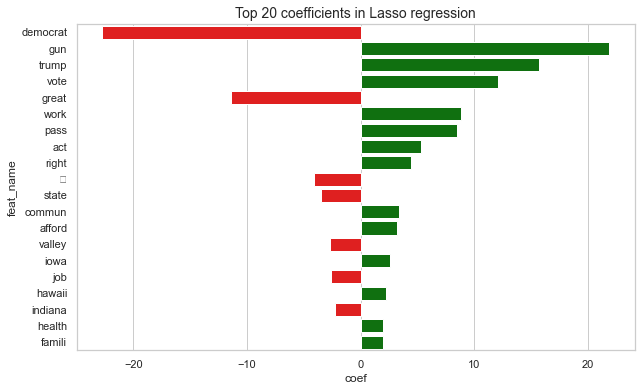

In [146]:
sns.set_style('whitegrid')

#Plotting the top 20 most impactful coefficients 
plt.figure(figsize = (10,6))

sns.barplot(x = 'coef',y = 'feat_name', data = lasso_coefs[:20], palette = lasso_coefs[:20].colors)
plt.title('Top 20 coefficients in Lasso regression', fontsize = 14);
